## Install

In [ ]:
# install
!pip install federpy

# import
from federpy.federpy import FederPy

### Data Preparation

In [ ]:
# index file built by hnswlib or faiss.
hnswSource = 'hnswlib'
hnswIndexFile = 'https://assets.zilliz.com/hnswlib_hnsw_voc_17k_1f1dfd63a9.index'

ivfflatSource = 'faiss'
ivfflatIndexFile = 'https://assets.zilliz.com/faiss_ivf_flat_voc_17k_ab112eec72.index'

In [ ]:
import pandas as pd

# this csv includes 17,000+ items，each only includes its filename.
namesFile = "https://assets.zilliz.com/voc_names_4cee9440b1.csv"

namesCsv = pd.read_csv(namesFile)
imageUrls = ["https://assets.zilliz.com/voc2012/JPEGImages/%s" % row['name'] for index, row in namesCsv.iterrows()]

## Vis for IVF_Flat (faiss)

In [ ]:
ivfflatViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls,
    "projectMethod": "umap",
}
federPy_ivfflat = FederPy(ivfflatIndexFile, ivfflatSource, **ivfflatViewParams)

### Overview

In [ ]:
federPy_ivfflat.overview()

### Search View

In [ ]:
federPy_ivfflat.setSearchParams({"k": 9, "nprobe": 8}).searchRandTestVec()

## Vis for HNSW (hnswlib)

In [ ]:
# init federpy
hnswViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls
}
federPy_hnsw = FederPy(hnswIndexFile, hnswSource, **hnswViewParams)

### Overview

In [ ]:
federPy_hnsw.overview()

### Search View

In [ ]:
federPy_hnsw.setSearchParams({"k": 6, "ef": 8}).searchRandTestVec()

## Code

### IVF, HNSW class

In [2]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


class IVF:

    def _compute_distance(self, data, q):
        """Compute the appropriate distance based on the distance type."""
        if self.distance_type == 'l2':
            return np.linalg.norm(data - q, axis=1)
        elif self.distance_type == 'cosine':
            return 1 - np.dot(data, q.T) / (np.linalg.norm(data, axis=1) * np.linalg.norm(q))


    def __init__(self, distance_type, n_clusters):

        self.n_clusters = n_clusters
        self.distance_type = distance_type
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.inverted_index = {i: [] for i in range(n_clusters)}
        self.data = None


    def fit(self, X):

        if self.distance_type == 'cosine':
            X = X / np.linalg.norm(X, axis=1, keepdims=True)

        self.kmeans.fit(X)
        labels = self.kmeans.labels_

        for idx, label in enumerate(labels):
            self.inverted_index[label].append(idx)

        self.data = X



    def search(self, q, k, n_probes=1):

        assert n_probes <= self.n_clusters

        if self.distance_type == "cosine":
            q = q / np.linalg.norm(q)

        cluster_distances = self._compute_distance(self.kmeans.cluster_centers_, q).flatten()
        probe_clusters = np.argpartition(cluster_distances, n_probes)[:n_probes]

        candidates = np.concatenate([self.inverted_index[cl] for cl in probe_clusters])

        if len(candidates) <= k:
            return candidates

        dists = self._compute_distance(self.data[candidates], q).flatten()
        top_idx = np.argpartition(dists, k)[:k]

        top_k = candidates[top_idx]
        top_dist = dists[top_idx]

        return [(k, dist) for k, dist in zip(top_k, top_dist)]



In [3]:
# -*- coding: utf-8 -*-
# https://github.com/RyanLiGod/hnsw-python/blob/master/hnsw.py

from heapq import heapify, heappop, heappush, heapreplace, nlargest
from math import log2
from operator import itemgetter
from random import random
import numpy as np

class HNSW(object):
    # self._graphs[level][i] contains a {j: dist} dictionary,
    # where j is a neighbor of i and dist is distance

    def l2_distance(self, a, b):
        return np.linalg.norm(a - b)

    def cosine_distance(self, a, b):
        try:
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        except ValueError:
            print(a)
            print(b)

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_type, M=5, efConstruction=200, Mmax=None):
        if distance_type == "l2":
            distance_func = self.l2_distance
        elif distance_type == "cosine":
            distance_func = self.cosine_distance
        else:
            raise TypeError('Please check your distance type!')
        self.distance_func = distance_func
        self.vectorized_distance = self.vectorized_distance_
        self._M = M
        self._efConstruction = efConstruction
        self._Mmax = 2 * M if Mmax is None else Mmax
        self._level_mult = 1 / log2(M)
        self._graphs = []
        self._enter_point = None
        self.data = []
        self.visit_count = 0

    ### Algorithm 1: INSERT
    def insert(self, q, efConstruction=None):

        if efConstruction is None:
            efConstruction = self._efConstruction

        distance = self.distance_func
        data = self.data
        graphs = self._graphs
        ep = self._enter_point
        M = self._M

        # line 4: determine level for the new element q
        l = int(-log2(random()) * self._level_mult) + 1
        idx = len(data)
        data.append(q)

        if ep is not None:
            neg_dist = -distance(q, data[ep])
            # distance(q, data[ep])

            # line 5-7: find the closest neighbor for levels above the insertion level
            for lc in reversed(graphs[l:]):
                neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

            # line 8-17: insert q at the relevant levels; W is a candidate list
            layer0 = graphs[0]
            for lc in reversed(graphs[:l]):
                M_layer = M if lc is not layer0 else self._Mmax

                # line 9: update W with the closest nodes found in the graph
                W = self._search_layer(q, [(neg_dist, ep)], lc, efConstruction)

                # line 10: insert the best neighbors for q at this layer
                lc[idx] = layer_idx = {}
                self._select(layer_idx, W, M_layer, lc, heap=True)

                # line 11-13: insert bidirectional links to the new node
                for j, dist in layer_idx.items():
                    self._select(lc[j], (idx, dist), M_layer, lc)

        # line 18: create empty graphs for all new levels
        for _ in range(len(graphs), l):
            graphs.append({idx: {}})
            self._enter_point = idx


    ### Algorithm 5: K-NN-SEARCH
    def search(self, q, K=5, efSearch=20):
        """Find the K points closest to q."""

        distance = self.distance_func
        graphs = self._graphs
        ep = self._enter_point
        self.visit_count = 0

        if ep is None:
            raise ValueError("Empty graph")

        neg_dist = -distance(q, self.data[ep])

        # line 1-5: search from top layers down to the second level
        for lc in reversed(graphs[1:]):
            neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

        # line 6: search with efSearch neighbors at the bottom level
        W = self._search_layer(q, [(neg_dist, ep)], graphs[0], efSearch)

        if K is not None:
            W = nlargest(K, W)
        else:
            W.sort(reverse=True)

        return [(idx, -md) for md, idx in W]


    ### Algorithm 2: SEARCH-LAYER
    def _search_layer(self, q, W, lc, ef):

        vectorized_distance = self.vectorized_distance
        data = self.data

        # Step 1: Initialize candidate list and visited set
        C = [(-neg_dist, idx) for neg_dist, idx in W]
        heapify(C)
        heapify(W)
        visited = set(idx for _, idx in W)

        # Step 4-17: Explore neighbors until candidate list is exhausted
        while C:
            dist, c = heappop(C)
            furthest = -W[0][0]
            if dist > furthest:
                break
            neighbors = [e for e in lc[c] if e not in visited]
            visited.update(neighbors)
            dists = vectorized_distance(q, [data[e] for e in neighbors])
            for e, dist in zip(neighbors, dists):
                self.visit_count += 1
                neg_dist = -dist
                if len(W) < ef:
                    heappush(C, (dist, e))
                    heappush(W, (neg_dist, e))
                    furthest = -W[0][0]
                elif dist < furthest:
                    heappush(C, (dist, e))
                    heapreplace(W, (neg_dist, e))
                    furthest = -W[0][0]

        return W

    ### Algorithm 3: SELECT-NEIGHBORS-SIMPLE
    def _select(self, R, C, M, lc, heap=False):

        if not heap:
            idx, dist = C
            if len(R) < M:
                R[idx] = dist
            else:
                max_idx, max_dist = max(R.items(), key=itemgetter(1))
                if dist < max_dist:
                    del R[max_idx]
                    R[idx] = dist
            return

        else:
            C = nlargest(M, C)
            R.update({idx: -neg_dist for neg_dist, idx in C})


### Data Preparation

In [4]:
import pandas as pd

train_raw = pd.read_parquet('openai_embedding_train.parquet')
train_raw.head()

_id  \
686                <dbpedia:Algebraic_geometry>   
7165                   <dbpedia:James_Blaylock>   
53822                <dbpedia:La_Cygne,_Kansas>   
42031                      <dbpedia:Mārikoriko>   
74442  <dbpedia:Upper_Saddle_River,_New_Jersey>   

                                title  \
686                Algebraic geometry   
7165                   James Blaylock   
53822                La Cygne, Kansas   
42031                      Mārikoriko   
74442  Upper Saddle River, New Jersey   

                                                    text  \
686    Algebraic geometry is a branch of mathematics,...   
7165   James Paul Blaylock (born September 20, 1950) ...   
53822  La Cygne (pronounced luh SEEN) is a city situa...   
42031  In a Māori legend attributed by White to the N...   
74442  Upper Saddle River is a borough in Bergen Coun...   

                                                  openai  
686    [0.0073704007, 0.016773129, 0.00032981095, -0....  
7165   [-0.016879516, -0.00453811, -0.015911562, -0.0...  
53822  [0.0038870506, 0.016870113, 0.0049162535, 0.01...  
42031  [-0.02006359, -0.03392973, -0.020258887, -0.00...  
74442  [0.007921013, 0.004799651, 0.014138309, -0.014...

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time

f = h5py.File('openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [6]:
distances

<HDF5 dataset "distances": shape (100, 100), type "<f8">

In [7]:
distances[0]

array([0.18023628, 0.18199849, 0.19761407, 0.20239192, 0.20566928,
       0.20731825, 0.20835632, 0.21049082, 0.21167642, 0.21186999,
       0.21456342, 0.2189573 , 0.21966851, 0.21986413, 0.2200197 ,
       0.22160095, 0.22203791, 0.22396915, 0.2240731 , 0.22436839,
       0.22584665, 0.2262705 , 0.22759867, 0.22831796, 0.22870576,
       0.22969215, 0.22984701, 0.23261583, 0.23263752, 0.23380172,
       0.23627774, 0.23633747, 0.23942387, 0.24004488, 0.24009627,
       0.24016446, 0.24083047, 0.24104905, 0.24112015, 0.24132645,
       0.24161463, 0.24238586, 0.24336779, 0.24444872, 0.24447459,
       0.24466473, 0.2450949 , 0.24516639, 0.24562347, 0.24564163,
       0.24572139, 0.24576478, 0.24611089, 0.24627946, 0.24634199,
       0.24644673, 0.24647534, 0.24690586, 0.24730973, 0.24737041,
       0.24895797, 0.24954307, 0.25012164, 0.25015455, 0.2510882 ,
       0.25342256, 0.25350779, 0.25392652, 0.25498772, 0.25530408,
       0.25627756, 0.25639355, 0.25669132, 0.25681838, 0.25688

In [8]:
neighbors

<HDF5 dataset "neighbors": shape (100, 100), type "<i8">

In [9]:
neighbors[0]

array([791, 199, 270, 498, 320, 628, 520, 739, 358,  35, 350, 387, 593,
       230,  52, 344, 644, 632,  78, 152, 678, 765, 780, 480, 831, 192,
       138, 519, 624,  49,  39,  19, 665, 315, 800, 813, 647, 575,  55,
       293, 186, 210, 627,  23, 865, 599, 158, 275, 573, 122, 860, 156,
       336,  30, 165, 425, 653, 402, 155, 706, 540, 509, 810, 348, 595,
       413, 640, 259, 184, 460, 442,  33, 533, 818, 252, 448, 176, 618,
       685, 125, 114, 169, 796, 313, 209, 341, 455, 175, 412, 222, 890,
       829, 118, 144, 376,  17,   1, 617, 424, 206])

In [10]:
train

<HDF5 dataset "train": shape (900, 1536), type "<f4">

In [11]:
test

<HDF5 dataset "test": shape (100, 1536), type "<f4">

### IVF code

In [12]:
ivf = IVF("cosine", n_clusters = 10)

ivf.fit(train)

In [72]:
## cluster 확인
# ivf.inverted_index

In [ ]:
## cluster별 데이터 수
for i in range(10):
    print(f"cluster {i} : {len(ivf.inverted_index[i])}")

cluster 0 : 155
cluster 1 : 110
cluster 2 : 69
cluster 3 : 97
cluster 4 : 142
cluster 5 : 69
cluster 6 : 96
cluster 7 : 43
cluster 8 : 93
cluster 9 : 26


In [ ]:
## centroid 확인
ivf.kmeans.cluster_centers_

array([[-0.00830691, -0.00424277,  0.00301853, ..., -0.01028011,
        -0.00920304, -0.01789439],
       [ 0.00249816, -0.00786838,  0.00605934, ..., -0.00959954,
        -0.01612761, -0.01387596],
       [-0.00669609, -0.01055885, -0.00645463, ..., -0.00760817,
        -0.00247431, -0.02117299],
       ...,
       [ 0.00704756,  0.00256868,  0.00463963, ...,  0.00095843,
        -0.01782914, -0.02531698],
       [-0.0150604 , -0.01518158, -0.00101238, ..., -0.01328445,
        -0.00461076, -0.01460836],
       [ 0.00127746, -0.00086746, -0.00283808, ..., -0.00187865,
        -0.00835771, -0.03159782]], dtype=float32)

In [ ]:
## search
ivf.search(test[0], 5)

[(199, 0.18199843),
 (791, 0.18023664),
 (498, 0.20239234),
 (270, 0.19761372),
 (320, 0.2056694)]

In [ ]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

### IVF 성능평가

In [ ]:
## index build time
n_clusters = [5, 10, 20]
times = []
for n_cluster in n_clusters:
    ivf = IVF("cosine", n_clusters = n_cluster)
    start = time.time()
    ivf.fit(train)
    times.append(time.time() - start)

for n_cluster, time_ in zip(n_clusters, times):
    print(f"n_cluster : {n_cluster}, build time : {time_}")


/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_cluster : 5, build time : 0.6696889400482178
n_cluster : 10, build time : 1.1074738502502441
n_cluster : 20, build time : 2.126772880554199


In [ ]:
## search speed and accuracy with different n_probe
ivf = IVF("cosine", n_clusters = 10)
ivf.fit(train)

n_probes = [1, 2, 3, 4]
qps_ivf = []
accuracies_ivf = []

for n_probe in n_probes:

    query_acc = []
    qps_ = []

    for i in range(len(test)):
        start = time.time()
        search_result = ivf.search(test[i], 5, n_probe)
        qps_.append(1 / (time.time() - start))

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)


    accuracies_ivf.append(np.mean(query_acc))
    qps_ivf.append(np.mean(qps_))

for n_probe, acc, qp in zip(n_probes, accuracies_ivf, qps_ivf):
    print(f"n_probe : {n_probe}, accuracy : {acc}, qps : {qp}")

/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_probe : 1, accuracy : 0.774, qps : 3092.5806113116164
n_probe : 2, accuracy : 0.904, qps : 1745.2971416854018
n_probe : 3, accuracy : 0.954, qps : 1438.2196539843176
n_probe : 4, accuracy : 0.978, qps : 818.0368624485501


In [ ]:
sns.lineplot(x = accuracies_ivf, y = qps_ivf)
sns.scatterplot(x = accuracies_ivf, y = qps_ivf, hue = n_probes, s = 50)
plt.xlabel("accuracy(recall)")
plt.ylabel("query per second")
plt.legend(title = "n_probe")
plt.title("accuracy vs query per second")
plt.show()

/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


### HNSW code

In [10]:
hnsw = HNSW("cosine", M = 8, efConstruction=50)

for i in range(len(train)):
    hnsw.insert(train[i])

In [ ]:
## hnsw index 확인
# hnsw._graphs

In [12]:
## layer별 노드 수
for i in range(len(hnsw._graphs)):
    print(f"layer {i} : {len(hnsw._graphs[i])}")

layer 0 : 900
layer 1 : 108
layer 2 : 13


In [13]:
## search

hnsw.search(test[0], 5)

[(791, 0.1802363395690918),
 (199, 0.18199855089187622),
 (270, 0.19761395454406738),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [14]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [21]:
## 평균 방문 노드 수 확인
visit = []
for i in range(len(test)):
    hnsw.search(test[i], 5, 20)
    visit.append(hnsw.visit_count)

print(np.mean(visit))

164.82


In [22]:
visit_k = []

for ef in [10, 20, 30]:
    visit = []
    for i in range(len(test)):
        hnsw.search(test[i], 5, ef)
        visit.append(hnsw.visit_count)

    visit_k.append(np.mean(visit))

visit_k

[115.04, 164.82, 208.52]

### HNSW 성능평가

In [ ]:
build_time_df = pd.DataFrame(columns=["M", "efConstruction", "build time"])

# Parameters
M = [4, 8, 16]
efConstruction = [20, 30, 40]

for m in M:
    for ef in efConstruction:
        hnsw = HNSW("cosine", M=m, efConstruction=ef)
        start = time.time()
        for i in range(len(train)):
            hnsw.insert(train[i])
        build_time = time.time() - start

        # Use pd.concat to add a row
        build_time_df = pd.concat(
            [build_time_df, pd.DataFrame({"M": [m], "efConstruction": [ef], "build time": [build_time]})],
            ignore_index=True
        )

/var/folders/l9/cp7frsgj2kzcg8x8z5n6sv440000gn/T/ipykernel_93148/205019155.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  build_time_df = pd.concat(


In [ ]:
build_time_df

M efConstruction  build time
0   4             20    1.730599
1   4             30    2.168374
2   4             40    2.424577
3   8             20    2.286838
4   8             30    3.212371
5   8             40    3.520917
6  16             20    2.910307
7  16             30    3.571751
8  16             40    4.176956

/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='M', ylabel='build time'>

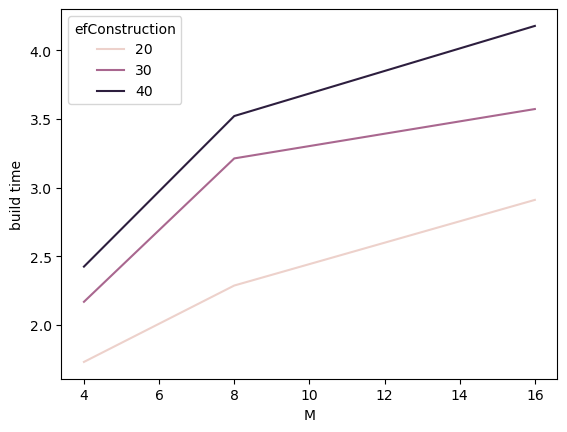

In [ ]:
sns.lineplot(x = 'M', y = 'build time', data = build_time_df, hue = 'efConstruction')

In [ ]:
## search speed and accuracy with different ef
hnsw = HNSW("cosine", M = 8, efConstruction=50)

for i in range(len(train)):
    hnsw.insert(train[i])

In [ ]:
efs = [10, 20, 30, 40]
accuracies_hnsw = []
qps_hnsw = []

for ef in efs:

    query_acc = []
    query_per_second = []

    for i in range(len(test)):
        start = time.time()
        search_result = hnsw.search(test[i], 5, ef)
        query_per_second.append(1 / (time.time() - start))

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

    qps_hnsw.append(np.mean(query_per_second))
    accuracies_hnsw.append(np.mean(query_acc))


for ef, acc, qp in zip(efs, accuracies_hnsw, qps_hnsw):
    print(f"ef : {ef}, accuracy : {acc}, qps : {qp}")


ef : 10, accuracy : 0.94, qps : 631.4910680467581
ef : 20, accuracy : 0.9720000000000002, qps : 502.5338949576063
ef : 30, accuracy : 0.98, qps : 339.7387230101391
ef : 40, accuracy : 0.986, qps : 280.23286179668634


/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jaewon/miniconda3/envs/hnsw/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


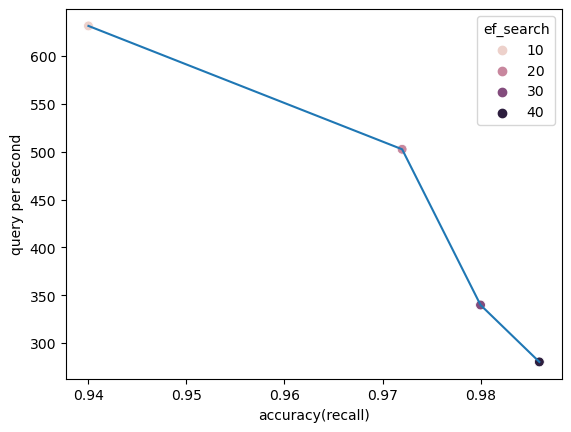

In [ ]:
sns.lineplot(x = accuracies_hnsw, y = qps_hnsw)
sns.scatterplot(x = accuracies_hnsw, y = qps_hnsw, hue = efs, s = 50)
plt.xlabel("accuracy(recall)")
plt.ylabel("query per second")
plt.legend(title = "ef_search")